In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

In [2]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


In [3]:
from scipy import signal
def compute_Reliability(spike_matrix,t,t_R):
    '''
    Computes the value of Reliability, a synchrony measurement that computes the variance of a convoluted spike train that is the sum of the spike trains of each neuron.

    Parameters:
        spike_matrix (tuple[tuple[int,int]] | sparse_matrix):
            matrix containing spike trains, each row contains a diffent neuron.
        t (list[float]):
            time array, time points of the simulation
        t_R (float):
            Time constant

    Returns:
        reliability / reliability_max (float):
            The computed value of reliability, normalised so (theorically) is between 0 and 1.
        Convolved_matrix (tuple[float]):
            The convolved spike train.
    '''

    #compute the time step of the simulation
    T = t[-1] - t[0]
    dt = T / len(t)

    #we need to work with a np.ndarray for the convolution, if it is a sparse_matrix, change it to that type
    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())

    #Compute the mean number of spikes
    num_spikes = (spike_matrix>0).sum()/num_neurons

    #Compute the kernel, and convolve the sum spike train with it
    joined_matrix = np.sum(spike_matrix,axis=0)
    kernel = 1/ t_R *np.exp(-t / t_R)
    Convolved_matrix = signal.convolve(joined_matrix,kernel)[0:len(spike_matrix[0,:])]
    #Convolved_matrix = joined_matrix

    #compute the measurements of reliability
    reliability = 1 / t[len(t) - 1] * np.trapz(np.square(Convolved_matrix), dx = dt) - np.square( 1 / t[len(t) - 1] * np.trapz(Convolved_matrix,dx =dt))
    reliability_max = ( num_neurons**2 * num_spikes / ( t_R * 2 * T ) - ( num_neurons * num_spikes / T )**2 )
    #reliability_max = 1
    return reliability/reliability_max, Convolved_matrix

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Average number of connections per neuron: 39.57
Connectivity Matrix g [[0.         0.42384853 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.37565821 0.        ]
 ...
 [0.         0.         0.30169669 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.38595867 0.26713488 ... 0.         0.         0.        ]]
Average value of matrix g= 0.04954971408890521


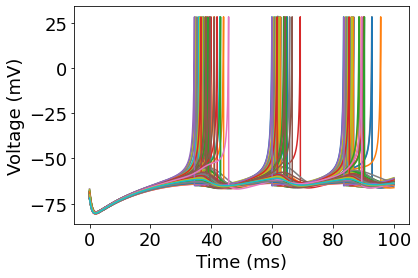

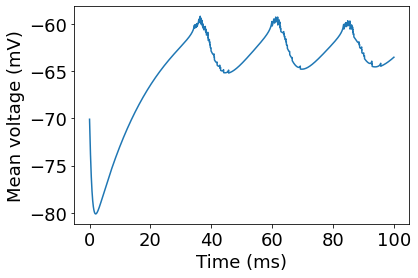

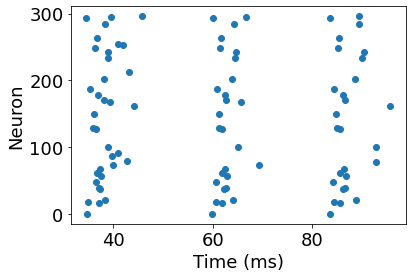

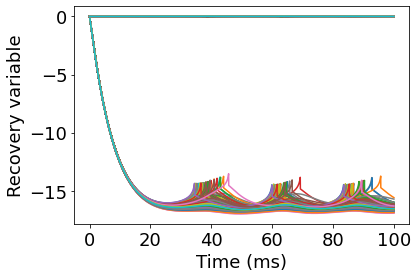

In [4]:
# Making neuron sparsely connected for second order synaptic term
# Has identical code to paper except different synaptic term (2nd order given by Aine)
# Changed the synaptic coupling to be probabilistic
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

np.random.seed(101)

N = 300
T = 100
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 2.72

J = np.random.normal(0, 0.25, size=(N))

I = 0.15

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 1, size=(N))
u_init = np.zeros(N)
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))

In [5]:
data = y_all[:N, :]
print(compute_chi(data))

0.6280060825913535


Reliability: 0.03302378145930404


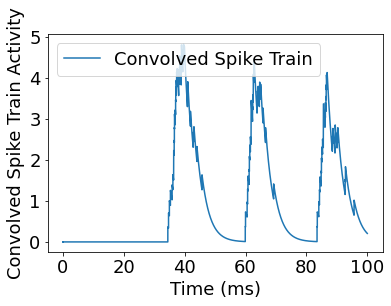

In [6]:
# Step 1: Create the spike_matrix
spike_matrix = np.zeros((N, len(t_all)))
num_neurons = 300
# For each spike recorded in spike_times, update the spike_matrix
for t, neuron in spike_times:
    # Find the index of the time point in t_all that is closest to the spike time `t`
    time_index = np.argmin(np.abs(t_all - t))
    spike_matrix[int(neuron), time_index] = 1  # Mark spike occurrence

# Step 2: Define the time constant and apply the reliability function
t_R = tauS  # Use the same tauS as the time constant for reliability

# Compute reliability
reliability_value, convolved_matrix = compute_Reliability(spike_matrix, t_all, t_R)

# Print the result
print(f"Reliability: {reliability_value}")

# Optionally, plot the convolved matrix to visualize the smoothed spike train activity
plt.figure()
plt.plot(t_all, convolved_matrix, label="Convolved Spike Train")
plt.xlabel('Time (ms)')
plt.ylabel('Convolved Spike Train Activity')
plt.legend()
plt.show()


Average number of connections per neuron: 299.0
Connectivity Matrix g [[0.         0.04954974 0.04954971 ... 0.04954977 0.04954968 0.04954973]
 [0.04954965 0.         0.04954971 ... 0.04954964 0.04954975 0.04954976]
 [0.04954977 0.04954972 0.         ... 0.04954961 0.04954978 0.0495497 ]
 ...
 [0.04954978 0.04954961 0.04954967 ... 0.         0.04954972 0.04954963]
 [0.04954971 0.0495498  0.04954964 ... 0.04954975 0.         0.04954961]
 [0.04954972 0.04954962 0.0495498  ... 0.04954975 0.04954966 0.        ]]
Average value of matrix g= 0.04938453454783924


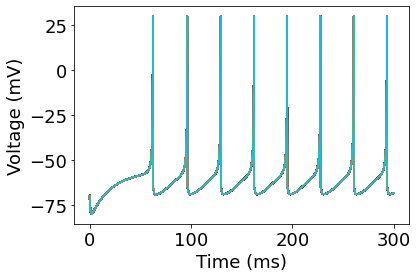

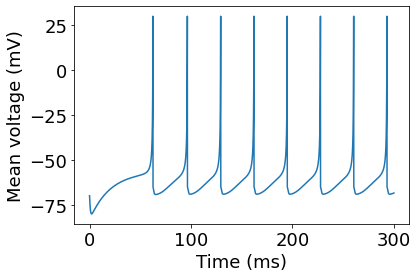

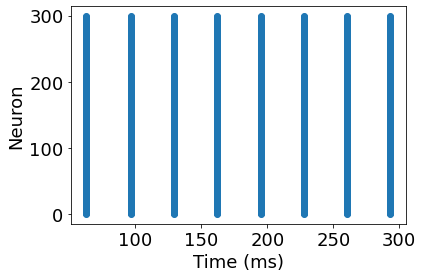

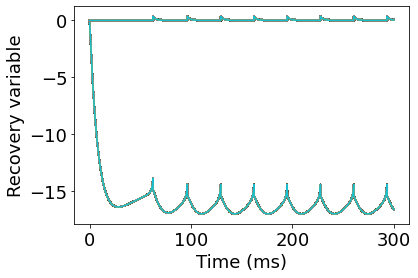

In [7]:
# Making neuron sparsely connected for second order synaptic term
# Has identical code to paper except different synaptic term (2nd order given by Aine)
# Changed the synaptic coupling to be probabilistic
# All to all connectivity
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 2.72

J = np.random.normal(0, 0, size=(N)) #Made this 0 to get them to spike at same time for all to all (Had std dev = 0.25 previous)
I = 0.15

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# # Sparsely connected networks with probabilistic connections
# for j in range(N):
#     for i in range(N):
#         if i != j:  # Avoid self-connections
#             if np.random.rand() < connection_probability:
#                 g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength 

# All-to-all connectivity
#g = np.random.uniform(0.25, 0.5, size=(N, N))
#g = np.ones((N, N))*0.04954971408890521 # Getting average value of sparse matrix and setting for all entries in all to all
g = np.random.uniform(0.0495496, 0.0495498, size=(N, N)) # Doesn't like a constant g matrix for some reason
np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 0, size=(N)) #Made this -70 for all constant spiking
u_init = np.zeros(N)
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))

In [8]:
data = y_all[:N, :]
print(compute_chi(data))

0.7215000813952192


Reliability: 0.8157983681095143


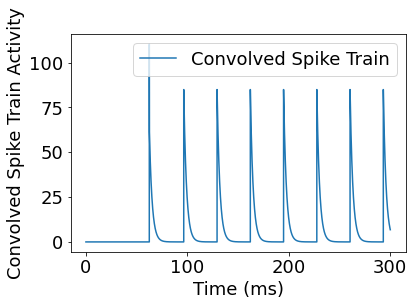

In [9]:
# Step 1: Create the spike_matrix
spike_matrix = np.zeros((N, len(t_all)))
num_neurons = N
# For each spike recorded in spike_times, update the spike_matrix
for t, neuron in spike_times:
    # Find the index of the time point in t_all that is closest to the spike time `t`
    time_index = np.argmin(np.abs(t_all - t))
    spike_matrix[int(neuron), time_index] = 1  # Mark spike occurrence

# Step 2: Define the time constant and apply the reliability function
t_R = tauS  # Use the same tauS as the time constant for reliability

# Compute reliability
reliability_value, convolved_matrix = compute_Reliability(spike_matrix, t_all, t_R)

# Print the result
print(f"Reliability: {reliability_value}")

# Optionally, plot the convolved matrix to visualize the smoothed spike train activity
plt.figure()
plt.plot(t_all, convolved_matrix, label="Convolved Spike Train")
plt.xlabel('Time (ms)')
plt.ylabel('Convolved Spike Train Activity')
plt.legend()
plt.show()


Average number of connections per neuron: 39.57
Connectivity Matrix g [[0.         0.42384853 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.37565821 0.        ]
 ...
 [0.         0.         0.30169669 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.38595867 0.26713488 ... 0.         0.         0.        ]]
Average value of matrix g= 0.04954971408890521


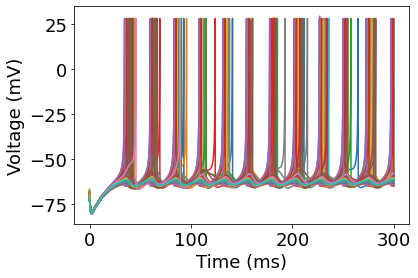

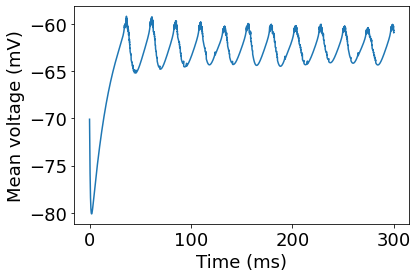

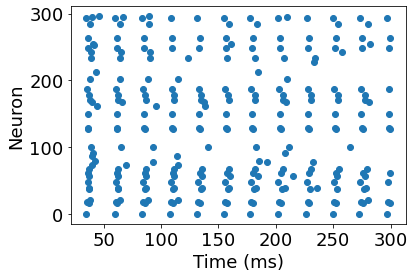

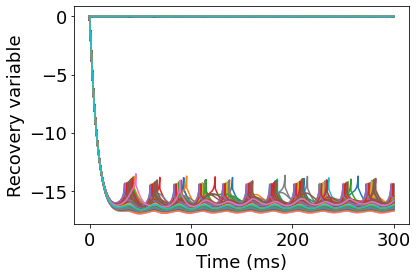

In [10]:
# Making neuron sparsely connected for second order synaptic term
# Has identical code to paper except different synaptic term (2nd order given by Aine)
# Changed the synaptic coupling to be probabilistic
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 2.72

J = np.random.normal(0, 0.25, size=(N))

I = 0.15

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 1, size=(N))
u_init = np.zeros(N)
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))

In [11]:
data = y_all[:N, :]
compute_chi(data)

0.3674322363984972

Reliability: 0.023189513280980806


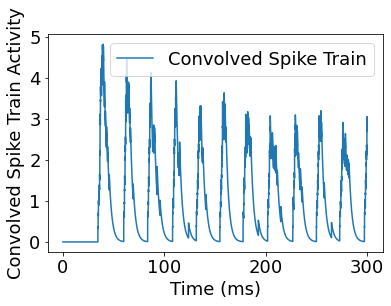

In [12]:
# Step 1: Create the spike_matrix
spike_matrix = np.zeros((N, len(t_all)))
num_neurons = N
# For each spike recorded in spike_times, update the spike_matrix
for t, neuron in spike_times:
    # Find the index of the time point in t_all that is closest to the spike time `t`
    time_index = np.argmin(np.abs(t_all - t))
    spike_matrix[int(neuron), time_index] = 1  # Mark spike occurrence

# Step 2: Define the time constant and apply the reliability function
t_R = tauS  # Use the same tauS as the time constant for reliability

# Compute reliability
reliability_value, convolved_matrix = compute_Reliability(spike_matrix, t_all, t_R)

# Print the result
print(f"Reliability: {reliability_value}")

# Optionally, plot the convolved matrix to visualize the smoothed spike train activity
plt.figure()
plt.plot(t_all, convolved_matrix, label="Convolved Spike Train")
plt.xlabel('Time (ms)')
plt.ylabel('Convolved Spike Train Activity')
plt.legend()
plt.show()
